In [27]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

n_hidden = 128.0
n_dim = 3.0

n_iterations = 30
qStart = 0.0

def LeakyReLU(x,neg_slope):
    if x >= 0:
        return x
    else:
        return -neg_slope * x

def integrand(z, prev_q):
    return np.tanh(np.sqrt(prev_q) * z)**2 * 1.0/np.sqrt(2.0 * np.pi) * np.exp(-(z**2)/2.0)

def test(z, a):
    return a*z**2

# nextq = weightVar * n_hidden * quad(integrad, -np.inf, np.inf, args=(qStart)) 
# + weightVar * n_dim * (dataVar + dataMean**2) + biasVar
def simulate(weightVar, dataVar, dataMean, biasVar):
    dynamics = np.zeros(n_iterations)
    for i in range(n_iterations):
        if i == 0:
            dynamics[i] = qStart
        else:
            dynamics[i] = weightVar * quad(integrand, -np.inf, np.inf, args=(dynamics[i-1]))[0] \
            + weightVar * (n_dim/n_hidden) * (dataVar + dataMean**2) + biasVar
    return dynamics

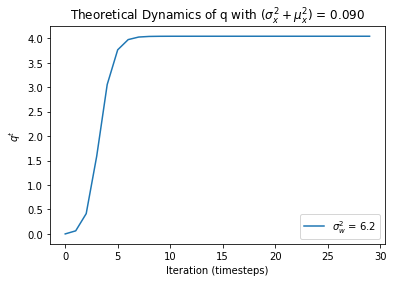

[ 0.          0.06312644  0.41515008  1.58995915  3.05598009  3.76612337
  3.97523859  4.02754697  4.04008709  4.0430626   4.04376689  4.0439335
  4.04397291  4.04398223  4.04398443  4.04398495  4.04398508  4.04398511
  4.04398511  4.04398511  4.04398511  4.04398511  4.04398511  4.04398511
  4.04398511  4.04398511  4.04398511  4.04398511  4.04398511  4.04398511]


In [28]:
weightStd = [2.5]
weightVar = [i**2 for i in weightStd]
biasVar = 0.05
# dataVar = 0
dataVar = 0.089609815596183001
dataMean = 0 # zero-mean
# dataMean = 0.273126
# dataVar = 0.193429 # non-zero mean
plt.figure(1)
for el in weightVar:
    output = simulate(el, dataVar, dataMean, biasVar)
    plt.plot(output, label=r'$\sigma_w^2$ = %.2g' % el)
    plt.xlabel("Iteration (timesteps)")
    plt.ylabel(r'$q^t$')
    plt.title(r'Theoretical Dynamics of q with $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
plt.legend()
plt.show()
print(output)

In [29]:
import pickle
import random
data_string = 'lorAtt_30'
with open('lorAttData/%s.pickle' % (data_string), 'rb') as f: #Eventually take the file name as an argument
    data = pickle.load(f)
random.seed(12345)


In [30]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import matplotlib.pyplot as plot
%matplotlib inline

traj = data[random.randint(0,len(data))]
traj = torch.FloatTensor(traj)

hidden_features = 128
n_dim = traj.size()[2]


weight_var = 2.5**2/hidden_features
weight_std = np.sqrt(weight_var)
weight_mean = 0.0
bias_mean = 0.0
bias_std = math.sqrt(0.05)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.activation = nn.Tanh()
        
        for m in self.modules():
                if isinstance(m, torch.nn.Linear):
                    m.weight.data.normal_(weight_mean, weight_std)
                    m.bias.data.normal_(bias_mean, bias_std)
        
    def forward(self, input, hidden):
        combined = torch.cat([input, hidden], 1)
        hidden = self.i2h(combined)
        pre_activation = hidden
        hidden = self.activation(hidden)
        output = self.i2o(combined)
        return output, hidden, pre_activation
    
    def initHidden(self):
        return Variable(torch.zeros(1,self.hidden_size)) 

10000


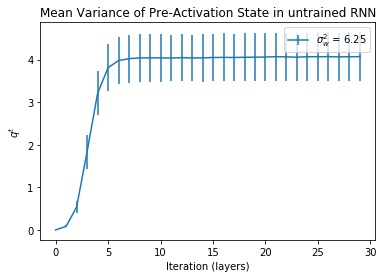

Data Mean = -0.000000
Data Variance = 0.089610
[0.0, 0.084433109, 0.53389347, 1.8345703, 3.2041378, 3.8103702, 3.9762359, 4.0206695, 4.0391054, 4.039072, 4.0403423, 4.0350356, 4.0441985, 4.0374045, 4.0397639, 4.0478077, 4.0512366, 4.0490141, 4.0536752, 4.055192, 4.0596128, 4.0675788, 4.0638113, 4.0570798, 4.0656362, 4.0670109, 4.0669737, 4.0633607, 4.0668697, 4.0667896]


In [31]:
variance_all = []
for j in range(len(data)):
    traj = data[j]
    encoderRNN = RNN(n_dim, hidden_features, n_dim)
    decoderRNN = RNN(n_dim, hidden_features, n_dim)
    traj = torch.FloatTensor(traj)

    input_sequence_length = 30
    variances = []
    hidden = encoderRNN.initHidden()
    variances.append(np.var(hidden.data.numpy()[0]))
    traj = Variable(traj)
    output_sequence_length = traj.size()[0] - input_sequence_length

    encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim))

    # Run the training sequence into the encoder
    for i in range(input_sequence_length):
        encoderOutput[i], hidden, pre_activation = encoderRNN(traj[i], hidden)
        variances.append(np.var(pre_activation.data.numpy()[0]))

    # Now the last hidden state of the encoder is the first hidden state of the decoder.
    # For now, let's have the first input be the origin
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) 
            decoderOutput[i], hidden, pre_activation = decoderRNN(dummyState, hidden)
            variances.append(np.var(pre_activation.data.numpy()[0]))
        else:
            decoderOutput[i], hidden, pre_activation = decoderRNN(decoderOutput[i-1], hidden)
            variances.append(np.var(pre_activation.data.numpy()[0]))
    if j == 0:
        variance_all = variances
    else:
        variance_all = np.vstack((variance_all, variances))
variance_mean = []
variance_std = []
for i in range(traj.size()[0]):
    variance_mean.append(np.mean(variance_all[:,i]))
    variance_std.append(np.sqrt(np.var(variance_all[:,i])))
print(len(variance_all))
variances = variance_mean
plt.errorbar(range(traj.size()[0]) ,variances, yerr=variance_std,  label=r'$\sigma_w^2$ = %g' % (weight_std**2 * hidden_features))
plt.xlabel("Iteration (layers)")
plt.ylabel(r'$q^t$')
plt.title('Mean Variance of Pre-Activation State in untrained RNN')
plt.legend()
plt.show()
print('Data Mean = %f' % np.mean(data))
print('Data Variance = %f' % np.var(data))
print(variances)

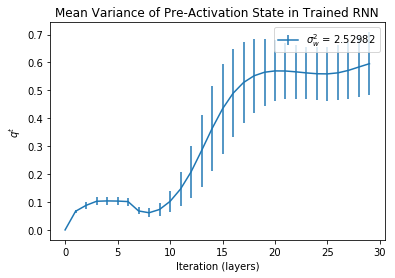

In [32]:
variance_all = []
for j in range(len(data)):
    traj = data[j]
    trainedEncoder = RNN(n_dim, hidden_features, n_dim)
    trainedDecoder = RNN(n_dim, hidden_features, n_dim)
    weight_std = 0.05
    trainedEncoder.load_state_dict(torch.load('savedResults/run_13/TrajModel/lorAtt_30_encoder_wsd_%.2f' % weight_std))
    trainedDecoder.load_state_dict(torch.load('savedResults/run_13/TrajModel/lorAtt_30_decoder_wsd_%.2f' % weight_std))
    traj = torch.FloatTensor(traj)

    input_sequence_length = 6
    variances = []
    hidden = trainedEncoder.initHidden()
    variances.append(np.var(hidden.data.numpy()[0]))
    traj = Variable(traj)
    output_sequence_length = traj.size()[0] - input_sequence_length

    encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim))

    # Run the training sequence into the encoder
    for i in range(input_sequence_length):
        encoderOutput[i], hidden, pre_activation = trainedEncoder(traj[i], hidden)
        variances.append(np.var(pre_activation.data.numpy()[0]))

    # Now the last hidden state of the encoder is the first hidden state of the decoder.
    # For now, let's have the first input be the origin
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) 
            decoderOutput[i], hidden, pre_activation = trainedDecoder(dummyState, hidden)
            variances.append(np.var(pre_activation.data.numpy()[0]))
        else:
            decoderOutput[i], hidden, pre_activation = trainedDecoder(decoderOutput[i-1], hidden)
            variances.append(np.var(pre_activation.data.numpy()[0]))
    if j == 0:
        variance_all = variances
    else:
        variance_all = np.vstack((variance_all, variances))
variance_mean = []
variance_std = []
for i in range(traj.size()[0]):
    variance_mean.append(np.mean(variance_all[:,i]))
    variance_std.append(np.sqrt(np.var(variance_all[:,i])))
    
variances = variance_mean
plt.errorbar(range(traj.size()[0]) ,variances, yerr=variance_std,  label=r'$\sigma_w^2$ = %g' % (np.sqrt(weight_std*hidden_features)))
plt.xlabel("Iteration (layers)")
plt.ylabel(r'$q^t$')
plt.title('Mean Variance of Pre-Activation State in Trained RNN')
plt.legend()
plt.show()

In [33]:
print(variances)

[0.0, 0.066874333, 0.08805079, 0.10269941, 0.10388354, 0.10336627, 0.10155387, 0.067983307, 0.061516371, 0.07328508, 0.10224224, 0.14654347, 0.20779201, 0.28392681, 0.36295706, 0.43389747, 0.48942715, 0.52817971, 0.55227751, 0.56505573, 0.56980157, 0.56946224, 0.56644171, 0.56263942, 0.55964833, 0.55913705, 0.56290454, 0.57175148, 0.58393699, 0.59572643]


-2.4576883738e-17
0.0896098155962
0.0896098155962


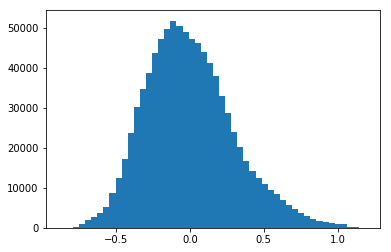

In [34]:
print(np.mean(data))
print(np.var(data))
temp = data.reshape(data.size, 1)
n, bins, patches = plt.hist(temp, 50)
print(np.mean(temp**2))
xvar = np.var(data[:,:,0,0])
yvar = np.var(data[:,:,0,1])
zvar = np.var(data[:,:,0,2])